In [1]:
import warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from haversine import haversine

sns.set_theme()
warnings.simplefilter(action='ignore', category=FutureWarning)

# Read and explore the data

In [2]:
df = pd.read_csv('../data/raw/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166915 entries, 0 to 1166914
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1166915 non-null  int64  
 1   vendor_id           1166915 non-null  int64  
 2   pickup_datetime     1166915 non-null  object 
 3   passenger_count     1166915 non-null  int64  
 4   pickup_longitude    1166915 non-null  float64
 5   pickup_latitude     1166915 non-null  float64
 6   dropoff_longitude   1166915 non-null  float64
 7   dropoff_latitude    1166915 non-null  float64
 8   store_and_fwd_flag  1166915 non-null  object 
 9   trip_duration       1166915 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 89.0+ MB


In [3]:
df.describe().round()

id  vendor_id  passenger_count  pickup_longitude  \
count  1166915.0  1166915.0        1166915.0         1166915.0   
mean    583457.0        2.0              2.0             -74.0   
std     336859.0        0.0              1.0               0.0   
min          0.0        1.0              0.0            -122.0   
25%     291728.0        1.0              1.0             -74.0   
50%     583457.0        2.0              1.0             -74.0   
75%     875186.0        2.0              2.0             -74.0   
max    1166914.0        2.0              9.0             -61.0   

       pickup_latitude  dropoff_longitude  dropoff_latitude  trip_duration  
count        1166915.0          1166915.0         1166915.0      1166915.0  
mean              41.0              -74.0              41.0          959.0  
std                0.0                0.0               0.0         5625.0  
min               34.0             -122.0              32.0            1.0  
25%               41.0              -74.0              41.0          397.0  
50%               41.0              -74.0              41.0          662.0  
75%               41.0              -74.0              41.0         1075.0  
max               52.0              -61.0              44.0      3526282.0

## 01 - Identify and Handle Anomalies

Analyze the daily trip count and identify two anomalous points in the data (e.g., unusually high or low demand).

In [4]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_date'] = df['pickup_datetime'].dt.date

daily_trips = df.groupby('pickup_date').size().reset_index(name='trip_count')

trips_mean = daily_trips['trip_count'].mean()
trips_std = daily_trips['trip_count'].std()

print("the trip count mean:", trips_mean)
print("the trip count standard deviation:", trips_std)

daily_trips.head()

the trip count mean: 6411.620879120879
the trip count standard deviation: 737.2980343015016


pickup_date  trip_count
0  2016-01-01        5718
1  2016-01-02        5204
2  2016-01-03        5118
3  2016-01-04        5416
4  2016-01-05        5775

Calculate the lower and upper pound of the normal trip count days, I have choose the $1.6$ value as a threshold after trying multiple values. 

In [5]:
threshold = 1.6

lower_pound = trips_mean - threshold * trips_std
upper_pound = trips_mean + threshold * trips_std

print("lower pound of trip count: ", lower_pound)
print("upper pound of trip count: ", upper_pound)

lower pound of trip count:  5231.944024238476
upper pound of trip count:  7591.297734003282


In [6]:
high_anomalies = daily_trips[daily_trips['trip_count'] > upper_pound]
low_anomalies = daily_trips[daily_trips['trip_count'] < lower_pound]

anomalous_days = pd.concat([high_anomalies, low_anomalies])

df['is_anomaly'] = 0
df.loc[df['pickup_date'].isin(anomalous_days['pickup_date']), 'is_anomaly'] = 1

df.head()

id  vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
0   0          2 2016-06-29 18:21:02                1        -73.862762   
1   1          2 2016-04-25 13:03:26                1        -73.958038   
2   2          2 2016-05-07 12:36:09                1        -73.969460   
3   3          1 2016-05-14 18:44:17                1        -73.981743   
4   4          2 2016-04-10 22:51:25                1        -73.977913   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0        40.768822         -73.891701         40.746689                  N   
1        40.783237         -73.975510         40.760853                  N   
2        40.785519         -73.989243         40.771748                  N   
3        40.736549         -73.998352         40.726440                  N   
4        40.752609         -73.975647         40.733139                  N   

   trip_duration pickup_date  is_anomaly  
0           1133  2016-06-29           0  
1            887  2016-04-25           0  
2            686  2016-05-07           0  
3            818  2016-05-14           0  
4            951  2016-04-10           0

Now, visualizing the trip count with the lower and upper bound.

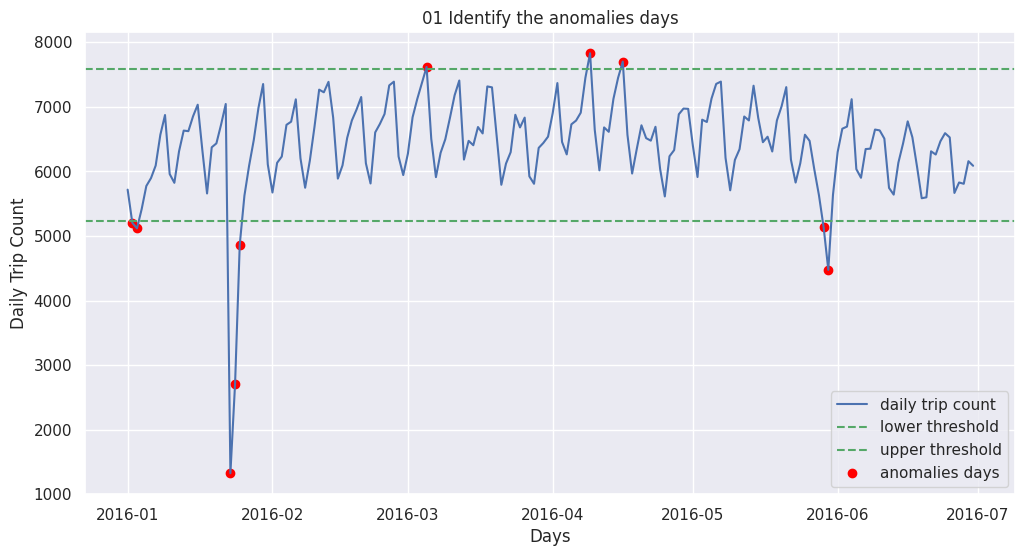

In [7]:
plt.figure(figsize=(12,6))
plt.plot(daily_trips['pickup_date'], daily_trips['trip_count'], label='daily trip count')
plt.axhline(y=lower_pound, color='g', linestyle='--', label='lower threshold')
plt.axhline(y=upper_pound, color='g', linestyle='--', label='upper threshold')
plt.scatter(anomalous_days['pickup_date'], anomalous_days['trip_count'], color='red', label='anomalies days')
plt.title('01 Identify the anomalies days')
plt.xlabel('Days')
plt.ylabel('Daily Trip Count')
plt.legend()
plt.show()

## 02 - Extract useful temporal features from the pickup_datetime column

- pickup_day_of_year (ordinal day of the year)
- pickup_day_of_week (0=Monday, 6=Sunday)
- pickup_hour_of_day (hour of the day).

In [8]:
df['pickup_day_of_year'] = df['pickup_datetime'].dt.dayofyear
df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday 
df['pickup_hour_of_day'] = df['pickup_datetime'].dt.hour

df[['pickup_day_of_year', 'pickup_day_of_week', 'pickup_hour_of_day']].head()

pickup_day_of_year  pickup_day_of_week  pickup_hour_of_day
0                 181                   2                  18
1                 116                   0                  13
2                 128                   5                  12
3                 135                   5                  18
4                 101                   6                  22

## 03 - Analyze Traffic Congestion 

Calculate the average speed (distance divided by trip duration) for trips based on the day of the week and hour of the day. Using this analysis to create a categorical feature for traffic congestion levels.

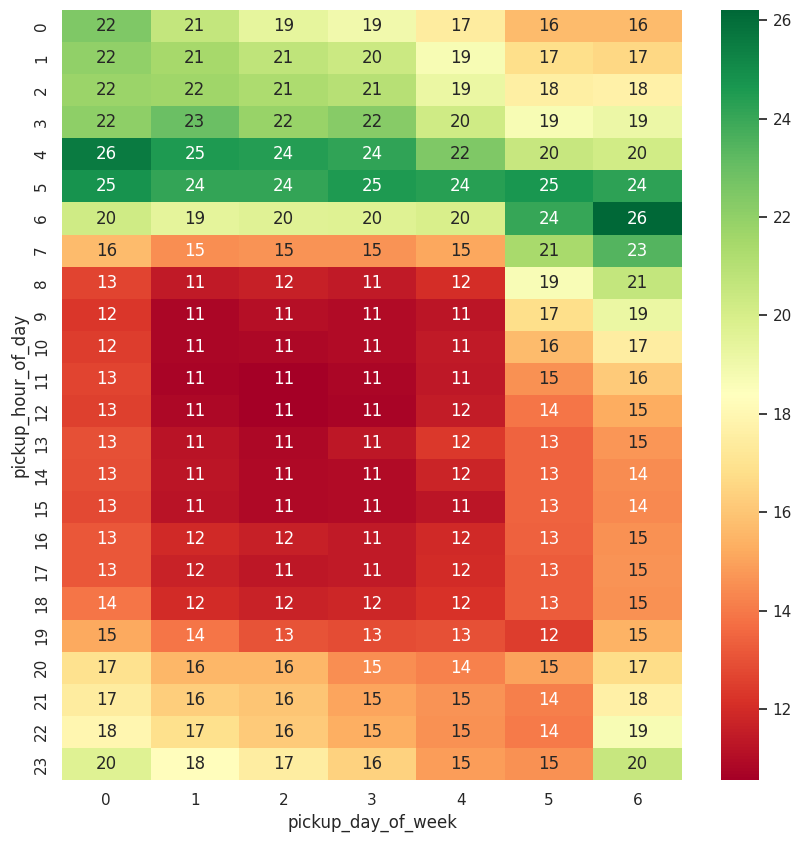

In [9]:
def vec_haversine(row):
    """function that calculates the distance from the latitude and longitude."""
    return haversine((row['pickup_latitude'], row['pickup_longitude']),(row['dropoff_latitude'], row['dropoff_longitude']))

df['trip_distance'] = df.apply(vec_haversine, axis=1)
df['speed'] = df['trip_distance'] / (df['trip_duration'] / 3600) # speed to be km/h

df_avg = df.groupby(['pickup_day_of_week', 'pickup_hour_of_day'])['speed'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,10))
df_temp = df_avg.pivot(index='pickup_hour_of_day', columns='pickup_day_of_week', values='speed')
sns.heatmap(df_temp, annot=True, ax=ax, cmap='RdYlGn')
plt.show()

Visualizing the high traffic, (expected as the average speed in these times are very low)

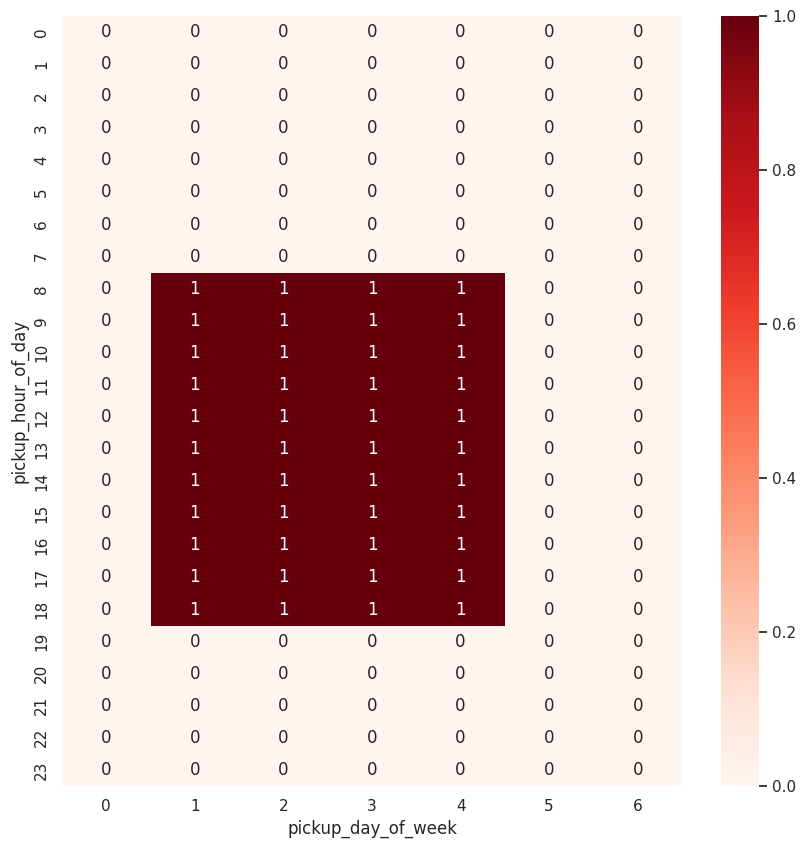

In [10]:
df_avg['traffic_congestion'] = 0
df_avg.loc[(((1 <= df_avg['pickup_day_of_week']) & (df_avg['pickup_day_of_week'] <= 4)) & \
            ((8 <= df_avg['pickup_hour_of_day']) & (df_avg['pickup_hour_of_day'] <= 18))), 'traffic_congestion'] = 1
df_grb = df_avg.groupby(['pickup_day_of_week', 'pickup_hour_of_day'])['traffic_congestion'].max().reset_index()
df_temp = df_avg.pivot(index='pickup_hour_of_day', columns='pickup_day_of_week', values='traffic_congestion')

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_temp, annot=True, ax=ax, cmap='Reds')
plt.show()

In [11]:
df['traffic_congestion'] = 0
df.loc[(((8 <= df['pickup_hour_of_day']) & (df['pickup_hour_of_day'] <= 18)) & \
            ((1 <= df['pickup_day_of_week']) & (df['pickup_day_of_week'] <= 4))), 'traffic_congestion'] = 1

df.head()

id  vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
0   0          2 2016-06-29 18:21:02                1        -73.862762   
1   1          2 2016-04-25 13:03:26                1        -73.958038   
2   2          2 2016-05-07 12:36:09                1        -73.969460   
3   3          1 2016-05-14 18:44:17                1        -73.981743   
4   4          2 2016-04-10 22:51:25                1        -73.977913   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0        40.768822         -73.891701         40.746689                  N   
1        40.783237         -73.975510         40.760853                  N   
2        40.785519         -73.989243         40.771748                  N   
3        40.736549         -73.998352         40.726440                  N   
4        40.752609         -73.975647         40.733139                  N   

   trip_duration pickup_date  is_anomaly  pickup_day_of_year  \
0           1133  2016-06-29           0                 181   
1            887  2016-04-25           0                 116   
2            686  2016-05-07           0                 128   
3            818  2016-05-14           0                 135   
4            951  2016-04-10           0                 101   

   pickup_day_of_week  pickup_hour_of_day  trip_distance      speed  \
0                   2                  18       3.463783  11.005842   
1                   0                  13       2.891369  11.734980   
2                   5                  12       2.262639  11.873909   
3                   5                  18       1.795032   7.899896   
4                   6                  22       2.173392   8.227351   

   traffic_congestion  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0

## 04 - Passenger Count Analysis

Explore the passenger_count column to identify:
- Common values (e.g., 1 or 2 passengers).
- Outliers (e.g., trips with zero or unusually high passenger counts).

In [12]:
passenger_count = df['passenger_count'].value_counts().sort_index()
print(passenger_count)

passenger_count
0        47
1    826979
2    168433
3     47778
4     22646
5     62383
6     38645
7         2
8         1
9         1
Name: count, dtype: int64


In [13]:
outliers = [0, 7, 8, 9]
df = df[~df['passenger_count'].isin(outliers)]

df.head()

id  vendor_id     pickup_datetime  passenger_count  pickup_longitude  \
0   0          2 2016-06-29 18:21:02                1        -73.862762   
1   1          2 2016-04-25 13:03:26                1        -73.958038   
2   2          2 2016-05-07 12:36:09                1        -73.969460   
3   3          1 2016-05-14 18:44:17                1        -73.981743   
4   4          2 2016-04-10 22:51:25                1        -73.977913   

   pickup_latitude  dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0        40.768822         -73.891701         40.746689                  N   
1        40.783237         -73.975510         40.760853                  N   
2        40.785519         -73.989243         40.771748                  N   
3        40.736549         -73.998352         40.726440                  N   
4        40.752609         -73.975647         40.733139                  N   

   trip_duration pickup_date  is_anomaly  pickup_day_of_year  \
0           1133  2016-06-29           0                 181   
1            887  2016-04-25           0                 116   
2            686  2016-05-07           0                 128   
3            818  2016-05-14           0                 135   
4            951  2016-04-10           0                 101   

   pickup_day_of_week  pickup_hour_of_day  trip_distance      speed  \
0                   2                  18       3.463783  11.005842   
1                   0                  13       2.891369  11.734980   
2                   5                  12       2.262639  11.873909   
3                   5                  18       1.795032   7.899896   
4                   6                  22       2.173392   8.227351   

   traffic_congestion  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0

### Visualize on a map

This function will be used to plot out the pickup and drop off locations on the map.

In [14]:
def show_circles_on_map(data: pd.DataFrame, latitude_column: str, longitude_column: str, color: str):
    """
    The function draws a map with circles on it.
    The center of the map is the mean of the coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

## 05 - Airport Proximity Features
Create binary features to indicate whether the trip started or ended at one of NYC’s major airports. Show on the map all trips that started near one of the airports in NY.

In [15]:
airports = [
    (40.6437, -73.7838), # JFK
    (40.7732, -73.8821), # LGA
    (40.6935, -74.1883)  # EWR
]

def is_near_airport(lat, lon, airport_coords, radius=1.5):
    return haversine((lat, lon), airport_coords) <= radius

df['pickup_near_airport'] = df.apply(lambda x: any(is_near_airport(x['pickup_latitude'], x['pickup_longitude'], airport) for airport in airports), axis=1)
df['dropoff_near_airport'] = df.apply(lambda x: any(is_near_airport(x['dropoff_latitude'], x['dropoff_longitude'], airport) for airport in airports), axis=1)

print("No. of trips starts near and airport: ", df[df['pickup_near_airport']].shape[0])
print("No. of trips ends up near and airport: ", df[df['dropoff_near_airport']].shape[0])

show_circles_on_map(df[df['pickup_near_airport']].sample(10000), 'pickup_latitude', 'pickup_longitude', 'blue')

No. of trips starts near and airport:  42913
No. of trips ends up near and airport:  23110


## 06 - Boundaries of NYC

Create binary features indicating whether the trip started or ended within the boundaries of NYC. Using geospatial libraries to define the boundaries of NYC.

In [16]:
import geopandas as gpd
from shapely.geometry import Point

In [17]:
url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
nyc_zones = gpd.read_file(url)

nyc_zones = nyc_zones.to_crs("EPSG:4326") # ensure its accuracy

gdf_taxi = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df['pickup_longitude'], df['pickup_latitude']),
    crs="EPSG:4326"
)

original_df_len = len(df)
df = gpd.sjoin(gdf_taxi, nyc_zones, how="inner", predicate="within")

accurate_df_len = len(df)

print("Original raws before filtering: ", original_df_len)
print("Accurate raws after filtering: ", accurate_df_len)

Original raws before filtering:  1166864
Accurate raws after filtering:  1165983


### Show the outliers on map

In [18]:
outliers = gdf_taxi[~gdf_taxi.index.isin(df.index)]
show_circles_on_map(outliers, 'pickup_latitude', 'pickup_longitude', 'blue')

## 07 - Analyze the NYC map and improve the distance calculation

In [19]:
import osmnx as ox
G = ox.graph_from_place('New York, USA', network_type='drive')

117948 578.8436170414994 35075.71567893287


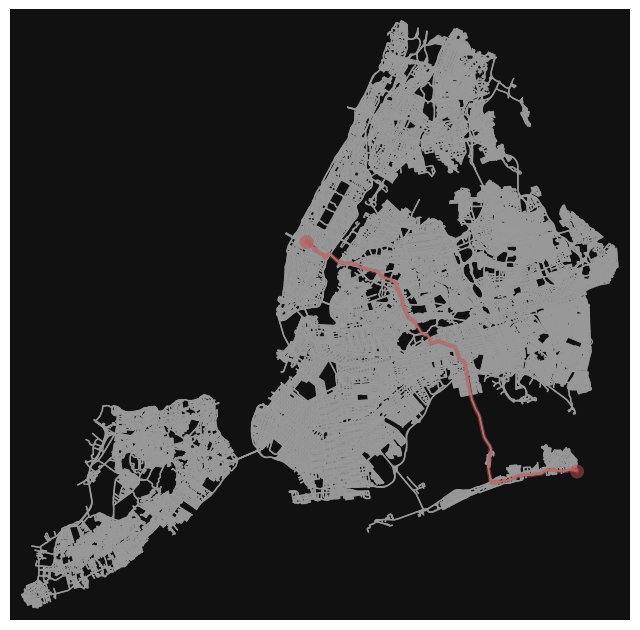

CPU times: user 9.16 s, sys: 176 ms, total: 9.34 s
Wall time: 10.1 s


In [20]:
%%time

row = df.loc[df['trip_distance'] == df['trip_distance'].max()]
pickup_longitude = row.iloc[0]['pickup_longitude']
pickup_latitude = row.iloc[0]['pickup_latitude']
dropoff_longitude = row.iloc[0]['dropoff_longitude']
dropoff_latitude = row.iloc[0]['dropoff_latitude']

pickup_node = ox.distance.nearest_nodes(G, pickup_longitude, pickup_latitude)
dropoff_node = ox.distance.nearest_nodes(G, dropoff_longitude, dropoff_latitude)
route_nodes = ox.shortest_path(G, pickup_node, dropoff_node, weight="length", cpus=None)
edge_lengths = ox.routing.route_to_gdf(G, route_nodes)

print(row.iloc[0].id, row.iloc[0].trip_distance, sum(edge_lengths["length"]))
fig, ax = ox.plot_graph_route(G, route_nodes, route_color="r", route_linewidth=3, node_size=0)
plt.show()

## 08 - Analyze and Clean Trip Duration:

- Plot the distribution of trip_duration and identify outliers (e.g., trips that are excessively short or long).
- Remove these outliers if they significantly distort the data, and justify your decision.

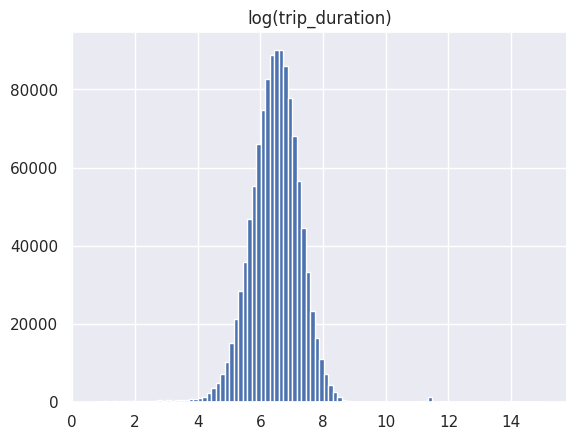

In [21]:
df['trip_duration'] = df['trip_duration'].apply(np.log1p)

plt.hist(df['trip_duration'], bins = 100)
plt.title('log(trip_duration)')
plt.show()

In [22]:
trip_duration_mean = df['trip_duration'].mean()
print("Trip duration mean: ", trip_duration_mean, np.expm1(trip_duration_mean))

min_duration, max_duration = 4, 8
print(f"Minimum Trip Duration: {np.expm1(min_duration)}")
print(f"Maximum Trip Duration: {np.expm1(max_duration)}")

previous_trips = df.shape[0]
df = df[(df['trip_duration'] >= min_duration) & (df['trip_duration'] <= max_duration)]

print(f'Removed: {previous_trips - df.shape[0]}')

Trip duration mean:  6.467998432562396 643.1930398851846
Minimum Trip Duration: 53.598150033144236
Maximum Trip Duration: 2979.9579870417283
Removed: 25294
